In [1]:
# This Python 3 environment comes with many helpful analytics libraries installedimport numpy as np # linear algebra
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
from keras.utils import HDF5Matrix
from PIL import Image

import tensorflow as tf
import keras
from keras.callbacks import Callback, ReduceLROnPlateau
from keras import backend as K
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array

from keras import Model
from keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import SGD, Adam
from keras.metrics import categorical_crossentropy

from keras.applications.xception import Xception

# data augmentation part
from random import sample, getrandbits
from PIL import ImageFilter, ImageEnhance
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import cv2
from skimage.color import rgb2hsv, hsv2rgb
from skimage.color import rgb2hed, hed2rgb
from skimage.exposure import rescale_intensity


import os
import time
from IPython import display

#print(os.listdir("../input"))

# directory to save the best model and last model
file_dir = '../working/Model'
if not os.path.exists(file_dir):
    os.mkdir(file_dir)

Using TensorFlow backend.


## Import Dataset

In [2]:
# Import dataset
x_train = HDF5Matrix('../input/camelyonpatch_level_2_split_train_x.h5-002/camelyonpatch_level_2_split_train_x.h5-002', 'x')
mask_train = HDF5Matrix('../input/camelyonpatch_level_2_split_train_mask.h5/camelyonpatch_level_2_split_train_mask.h5', 'mask')
y_train = HDF5Matrix('../input/camelyonpatch_level_2_split_train_y.h5/camelyonpatch_level_2_split_train_y.h5', 'y')               
x_val = HDF5Matrix('../input/camelyonpatch_level_2_split_valid_x.h5/camelyonpatch_level_2_split_valid_x.h5', 'x')
y_val = HDF5Matrix('../input/camelyonpatch_level_2_split_valid_y.h5/camelyonpatch_level_2_split_valid_y.h5', 'y')
x_test = HDF5Matrix('../input/camelyonpatch_level_2_split_test_x.h5/camelyonpatch_level_2_split_test_x.h5', 'x')



## Data Augmentation

In [3]:
# Mirroring
def mirroring(image):
    a = getrandbits(2)
    if a == 3:
        im_aug = np.fliplr(np.flipud(image))
    elif a == 2:
        im_aug = np.flipud(image)
    elif a == 1:
        im_aug = np.fliplr(image)
    else:
        im_aug = image
    return im_aug

# elastic deformation
def elastic_transform(image, alpha, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
    assert len(image.shape)==3

    if random_state is None:
        random_state = np.random.RandomState(None)

    shape_2d = image[:,:,0].shape

    dx = gaussian_filter((random_state.rand(*shape_2d) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape_2d) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape_2d[0]), np.arange(shape_2d[1]), indexing='ij')
    indices = np.reshape(x+dx, (-1, 1)), np.reshape(y+dy, (-1, 1))
    
    r = map_coordinates(image[:,:,0], indices, order=1).reshape(shape_2d)
    g = map_coordinates(image[:,:,1], indices, order=1).reshape(shape_2d)
    b = map_coordinates(image[:,:,2], indices, order=1).reshape(shape_2d)
   
    return np.stack((r,g,b), axis=2)

# Gaussian noise
def gaussian_noise(image, sigma):
    gaussian = np.random.normal(0, sigma, image[:,:,0].shape)
    noisy_image = np.zeros(image.shape, np.float32)

    if len(image.shape) == 2:
        noisy_image = image + gaussian
    else:
        noisy_image[:, :, 0] = image[:, :, 0] + gaussian
        noisy_image[:, :, 1] = image[:, :, 1] + gaussian
        noisy_image[:, :, 2] = image[:, :, 2] + gaussian

    cv2.normalize(noisy_image, noisy_image, 0, 255, cv2.NORM_MINMAX, dtype=-1)
    noisy_image = noisy_image.astype(np.uint8)
    
    return noisy_image

# HSV perturbation
def hsv_shifting(image, ratio):
    hsv_im = rgb2hsv(image)
    
    a = np.random.uniform(low= 1-ratio, high= 1+ratio, size=1)[0]
    b = np.random.uniform(low= -ratio, high= ratio, size=1)[0]
    
    hsv_im[:,:,0] = a * hsv_im[:,:,0] + b
    hsv_im[:,:,1] = a * hsv_im[:,:,1] + b
    
    
    new_im = hsv2rgb(hsv_im)
    
    return new_im

# HED perturbation
def hed_shifting(image, ratio):
    hed_im = rgb2hed(image)
    
    a = np.random.uniform(low= 1-ratio, high= 1+ratio, size=1)[0]
    b = np.random.uniform(low= -ratio, high= ratio, size=1)[0]
    
    hed_im[:,:,0] = a * hed_im[:,:,0] + b 
    hed_im[:,:,1] = a * hed_im[:,:,1] + b

    
    new_im = hed2rgb(hed_im)
    
    return new_im

# Data Augmentation function
def Augmentation(image, rot=[0, 90], elast_a=[80, 120], elast_sig=[9.0 , 11.0], g_noise=[0,0.1],
                g_blurr=[0,0.1], brigh=[0.65,1.35], contr=[0.5,1.5], HSV=0.1, HED=None):
    
    # random rotation
    angle = sample(rot, 1)
    im = Image.fromarray(image)
    im = im.rotate(angle[0])
    im = np.array(im)
    
    # random mirroring
    im = mirroring(im)
    
    # random elastic trasform
    if getrandbits(1) > 0:
        a = np.random.uniform(low=elast_a[0], high=elast_a[1], size=1)[0]
        s = np.random.uniform(low=elast_sig[0], high=elast_sig[1], size=1)[0]
        im = elastic_transform(im, a, s)
        
    # random gaussian noise
    if getrandbits(1) > 0:
        sigma = np.random.uniform(low=g_noise[0], high=g_noise[1], size=1)[0]
        im = gaussian_noise(im, sigma)
        
    # random gaussian blurring
    if getrandbits(1) > 0:
        sigma = np.random.uniform(low=g_blurr[0], high=g_blurr[1], size=1)[0]
        im = Image.fromarray(im)
        out = im.filter(ImageFilter.GaussianBlur(sigma))
        im = np.array(im)
        
    # random brightness perturbation
    if getrandbits(1) > 0:
        br = np.random.uniform(low=brigh[0], high=brigh[1], size=1)[0]
        im = Image.fromarray(im)
        im = ImageEnhance.Brightness(im)
        im = im.enhance(br)
        im = np.array(im)
        
    # random contrast perturbation
    if getrandbits(1) > 0:
        cr = np.random.uniform(low=contr[0], high=contr[1], size=1)[0]
        im = Image.fromarray(im)
        im = ImageEnhance.Contrast(im)
        im = im.enhance(cr)
        im = np.array(im)
        
        
    hsv_flag = False
    # Hsv perturbation 
    if HSV is not None:
        hsv_flag = True
        im = hsv_shifting(im, HSV)
        
    # Hed perturbation (only if hsv not performed!)
    if (not hsv_flag) and (HED is not None):
        im = hed_shifting(im, HED)
    
    return im


## Data Generator

In [4]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, data, labels, Aug=True, batch_size=32, dim=(224, 224), n_channels=3,
                 n_classes=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.data = data
        self.labels = labels
        self.Aug = Aug
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.n_classes))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # preprocessing
            img_arr = self.data[ID]
            img = array_to_img(img_arr)
            img = img.resize((224,224), Image.ANTIALIAS)
            img.load()
            
            if self.Aug:
                X[i] = Augmentation(np.asarray(img, dtype=np.uint8), rot=[0, 90], elast_a=[80, 120],
                                elast_sig=[9.0 , 11.0], g_noise=[0,0.1], g_blurr=[0,0.1],
                                brigh=[0.65,1.35], contr=[0.5,1.5], HSV=0.1, HED=None)
            else:
                X[i] = np.asarray(img, dtype=np.uint8)/255
            
            
            # Store target label(one-hot-encoding)
            y[i] = to_categorical(self.labels[str(ID)], num_classes=self.n_classes)

        return X, y

## Callbacks

In [5]:
#Callback: TimerCallback()
# this callback make sure to interrupt the training if a certain time limit is reached, saving the weigths of the last model to train again

class TimerCallback(Callback):
    
    def __init__(self, maxExecutionTime, byBatch = False, on_interrupt=None):
        
# Arguments:
#     maxExecutionTime (number): Time in minutes. The model will keep training 
#                                until shortly before this limit
#                                (If you need safety, provide a time with a certain tolerance)

#     byBatch (boolean)     : If True, will try to interrupt training at the end of each batch
#                             If False, will try to interrupt the model at the end of each epoch    
#                            (use `byBatch = True` only if each epoch is going to take hours)          

#     on_interrupt (method)          : called when training is interrupted
#         signature: func(model,elapsedTime), where...
#               model: the model being trained
#               elapsedTime: the time passed since the beginning until interruption   

        
        self.maxExecutionTime = maxExecutionTime * 60
        self.on_interrupt = on_interrupt
        
        #the same handler is used for checking each batch or each epoch
        if byBatch == True:
            #on_batch_end is called by keras every time a batch finishes
            self.on_batch_end = self.on_end_handler
        else:
            #on_epoch_end is called by keras every time an epoch finishes
            self.on_epoch_end = self.on_end_handler
    
    
    #Keras will call this when training begins
    def on_train_begin(self, logs):
        self.startTime = time.time()
        self.longestTime = 0            #time taken by the longest epoch or batch
        self.lastTime = self.startTime  #time when the last trained epoch or batch was finished
    
    
    #this is our custom handler that will be used in place of the keras methods:
        #`on_batch_end(batch,logs)` or `on_epoch_end(epoch,logs)`
    def on_end_handler(self, index, logs):
        
        currentTime      = time.time()                           
        self.elapsedTime = currentTime - self.startTime    #total time taken until now
        thisTime         = currentTime - self.lastTime     #time taken for the current epoch
                                                               #or batch to finish
        
        self.lastTime = currentTime
        
        #verifications will be made based on the longest epoch or batch
        if thisTime > self.longestTime:
            self.longestTime = thisTime
        
        
        #if the (assumed) time taken by the next epoch or batch is greater than the
            #remaining time, stop training
        remainingTime = self.maxExecutionTime - self.elapsedTime
        if remainingTime < self.longestTime:
            
            self.model.stop_training = True  #this tells Keras to not continue training
            print("\n\nTimerCallback: Finishing model training before it takes too much time. (Elapsed time: " + str(self.elapsedTime/60.) + " minutes )\n\n")
            
            #if we have passed the `on_interrupt` callback, call it here
            if self.on_interrupt is not None:
                self.on_interrupt(self.model, self.elapsedTime)

In [6]:
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

class PlotCurves(Callback):
    # Callback: PlotCurves
    # plot losses and accuracy after each epoch and save the weights of the best model
    def on_train_begin(self, logs={}):
        self.epoch = 0
        self.best_epoch = 0
        self.best_auc_epoch = 0
        self.x = []
        self.losses = []
        self.acc = []
        self.auc = []
        self.val_losses = []
        self.val_acc = []
        self.val_auc = []
        self.best_val_acc = 0
        self.best_val_auc = 0
        self.fig = plt.figure(figsize=(10, 5))
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.fig = plt.figure(figsize=(10, 5))
        self.logs.append(logs)
        self.x.append(self.epoch)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.auc.append(logs.get('auc'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))
        self.val_auc.append(logs.get('val_auc'))
        self.epoch += 1
        
        # (Possibly) update best validation accuracy and save the network
        if self.val_acc[-1] > self.best_val_acc:
            self.best_val_acc = self.val_acc[-1]
            self.best_epoch = self.epoch
            self.model.save_weights(os.path.join(file_dir, 'best_acc_model.h5'))
            
        # (Possibly) update best validation AUC and save the network
        if self.val_auc[-1] > self.best_val_auc:
            self.best_val_auc = self.val_auc[-1]
            self.best_auc_epoch = self.epoch
            self.model.save_weights(os.path.join(file_dir, 'best_auc_model.h5'))
        
        display.clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.plot(self.x, self.acc, label="acc")
        plt.plot(self.x, self.val_acc, label="val_acc")
        plt.plot(self.x, self.auc, label="auc")
        plt.plot(self.x, self.val_auc, label="val_auc")
        plt.legend()
        plt.title('Best validation accuracy = {:.2f}% on epoch {} of {} \n' \
                  'Best validation AUC = {:.2f}% on epoch {} of {}'.format(
                        100. * self.best_val_acc, self.best_epoch, self.epoch,
                        100. * self.best_val_auc, self.best_auc_epoch, self.epoch))
        plt.show();

In [7]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3,
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

## Model

In [8]:
inc = Xception(weights='imagenet', include_top=False, input_shape=(224,224,3))

Instructions for updating:
Colocations handled automatically by placer.
83689472/83683744 [==============================] - 8s 0us/step


In [9]:
inc.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [10]:
x = inc.output
x = GlobalAveragePooling2D()(x)

x = Dense(256, activation='relu')(x)
#x = Dropout(0.5)(x)

y = Dense(2, activation='softmax')(x) # sigmoid instead of softmax to have independent probabilities

model = Model(inputs=inc.input, outputs=y)

# Train only the top layer
for layer in inc.layers:
    layer.trainable = False

In [11]:
# Check model
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [12]:
optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#optimizer = Adam(lr=0.01, beta_1=0.9, beta_2=0.999)

loss = 'categorical_crossentropy'
metrics = ['acc', auc]

In [13]:
model.compile(optimizer, loss, metrics)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


## Training

In [14]:
# to test the model first, train with few sample and see if it overfits
train_limit = 10
if train_limit is not None:
    val_limit = int(np.floor(train_limit / (len(x_train) / len(x_val))))
    
    x_train = x_train[:train_limit]
    y_train = y_train[:train_limit]
    x_val = x_val[:val_limit]
    y_val = y_val[:val_limit]

# Check dimensions
print("Training set")
print("img:",x_train.shape)
print("labels:",y_train.shape)
print('-'*40)
print("Validation set")
print("img:",x_val.shape)
print("labels:",y_val.shape)
print('-'*40)
print("Test set")
print("img:",x_test.shape)

# indexes to feed the generator
train_id = np.arange(len(x_train))
val_id = np.arange(len(x_val))

# creat a useful dictionary structures
partition = {}
partition['train'] = train_id
partition['validation'] = val_id

train_labels = {}
val_labels = {}

for i in range(len(train_id)):
    
    train_labels[str(i)] = y_train[i].flatten()[0] 
    
for i in range(len(val_id)):
    
    val_labels[str(i)] = y_val[i].flatten()[0]


# Define batch size.
batch_size = 1
n_epoch = 30
time_limit = 480 # time limit in minute (480 -> 8 hrs )

# Parameters for generators
train_params = {
    'dim': (224, 224),
    'Aug': False,
    'batch_size': batch_size,
    'n_classes': 2,
    'shuffle': False
}

val_params = {
    'dim': (224, 224),
    'Aug': False,
    'batch_size': batch_size,
    'n_classes': 2,
    'shuffle': False
}

# verbosity
ver = 1

# Generators
training_generator = DataGenerator(partition['train'], x_train, train_labels, **train_params)
validation_generator = DataGenerator(partition['validation'], x_val, val_labels, **val_params)

#a function to save last_model compatible with the on_interrupt handler of TimerCallback
def saveWeights(model, elapsed):
    model.save_weights(os.path.join(file_dir, 'last_model.h5'))


# Callbacks,
callbacks = [PlotCurves(), learning_rate_reduction]#, TimerCallback(time_limit, on_interrupt=saveWeights)]

Training set
img: (10, 96, 96, 3)
labels: (10, 1, 1, 1)
----------------------------------------
Validation set
img: (1, 96, 96, 3)
labels: (1, 1, 1, 1)
----------------------------------------
Test set
img: (32768, 96, 96, 3)


In [15]:
model.evaluate_generator(generator=validation_generator)

[0.949934720993042, 0.0, 9.999981784858392e-07]

In [16]:
# Check if model overfit on small training set
model.fit_generator(generator=training_generator, epochs=n_epoch)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
10/10 [==============================] - 1s 117ms/step - loss: 0.8871 - acc: 0.6000 - auc: 0.4661
Epoch 2/30
10/10 [==============================] - 0s 16ms/step - loss: 0.7917 - acc: 0.6000 - auc: 0.5183
Epoch 3/30
10/10 [==============================] - 0s 20ms/step - loss: 0.7264 - acc: 0.3000 - auc: 0.5273
Epoch 4/30
10/10 [==============================] - 0s 20ms/step - loss: 0.6715 - acc: 0.8000 - auc: 0.5211
Epoch 5/30
10/10 [==============================] - 0s 20ms/step - loss: 0.6686 - acc: 0.6000 - auc: 0.5350
Epoch 6/30
10/10 [==============================] - 0s 20ms/step - loss: 0.6851 - acc: 0.6000 - auc: 0.5617
Epoch 7/30
10/10 [==============================] - 0s 20ms/step - loss: 0.6886 - acc: 0.6000 - auc: 0.5550
Epoch 8/30
10/10 [==============================] - 0s 20ms/step - loss: 0.6708 - acc: 0.6000 - auc: 0.5650
Epoch 9/30
10/10 [==============================] - 0s 21ms/step - loss: 0.6693 - acc: 

In [17]:
# Import (again) dataset
x_train = HDF5Matrix('../input/camelyonpatch_level_2_split_train_x.h5-002/camelyonpatch_level_2_split_train_x.h5-002', 'x')
mask_train = HDF5Matrix('../input/camelyonpatch_level_2_split_train_mask.h5/camelyonpatch_level_2_split_train_mask.h5', 'mask')
y_train = HDF5Matrix('../input/camelyonpatch_level_2_split_train_y.h5/camelyonpatch_level_2_split_train_y.h5', 'y')               
x_val = HDF5Matrix('../input/camelyonpatch_level_2_split_valid_x.h5/camelyonpatch_level_2_split_valid_x.h5', 'x')
y_val = HDF5Matrix('../input/camelyonpatch_level_2_split_valid_y.h5/camelyonpatch_level_2_split_valid_y.h5', 'y')
x_test = HDF5Matrix('../input/camelyonpatch_level_2_split_test_x.h5/camelyonpatch_level_2_split_test_x.h5', 'x')



In [18]:
# if it overfits, try to raise the sample size. None to train with full dataset
train_limit = None
if train_limit is not None:
    val_limit = int(np.floor(train_limit / (len(x_train) / len(x_val))))
    
    x_train = x_train[:train_limit]
    y_train = y_train[:train_limit]
    x_val = x_val[:val_limit]
    y_val = y_val[:val_limit]

# Check dimensions
print("Training set")
print("img:",x_train.shape)
print("labels:",y_train.shape)
print('-'*40)
print("Validation set")
print("img:",x_val.shape)
print("labels:",y_val.shape)
print('-'*40)
print("Test set")
print("img:",x_test.shape)

# indexes to feed the generator
train_id = np.arange(len(x_train))
val_id = np.arange(len(x_val))

# creat a useful dictionary structures
partition = {}
partition['train'] = train_id
partition['validation'] = val_id

train_labels = {}
val_labels = {}

for i in range(len(train_id)):
    
    train_labels[str(i)] = y_train[i].flatten()[0] 
    
for i in range(len(val_id)):
    
    val_labels[str(i)] = y_val[i].flatten()[0]


# Define batch size.
batch_size = 128
n_epoch = 100
time_limit = 480 # time limit in minute (480 -> 8 hrs )

# Parameters for generators
train_params = {
    'dim': (224, 224),
    'Aug': False,
    'batch_size': batch_size,
    'n_classes': 2,
    'shuffle': False
}

val_params = {
    'dim': (224, 224),
    'Aug': False,
    'batch_size': batch_size,
    'n_classes': 2,
    'shuffle': False
}

# verbosity
ver = 2

# Generators
training_generator = DataGenerator(partition['train'], x_train, train_labels, **train_params)
validation_generator = DataGenerator(partition['validation'], x_val, val_labels, **val_params)

#a function to save last_model compatible with the on_interrupt handler of TimerCallback
def saveWeights(model, elapsed):
    model.save_weights(os.path.join(file_dir, 'last_model.h5'))


# Callbacks,
callbacks = [PlotCurves(), learning_rate_reduction, TimerCallback(time_limit, on_interrupt=saveWeights)]

Training set
img: (262144, 96, 96, 3)
labels: (262144, 1, 1, 1)
----------------------------------------
Validation set
img: (32768, 96, 96, 3)
labels: (32768, 1, 1, 1)
----------------------------------------
Test set
img: (32768, 96, 96, 3)


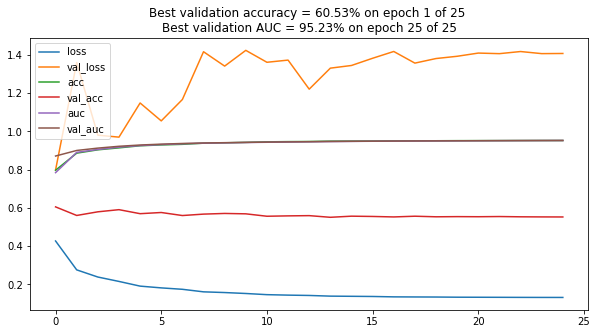



TimerCallback: Finishing model training before it takes too much time. (Elapsed time: 469.49130692879356 minutes )




In [19]:
# Training
train = model.fit_generator(training_generator, validation_data=validation_generator, 
                    epochs=n_epoch, callbacks=callbacks, verbose=ver)

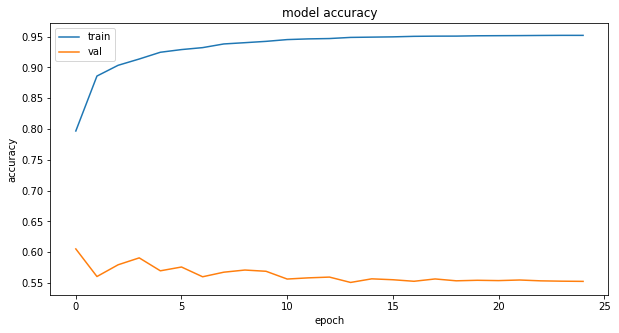

In [20]:
# summarize history for accuracy
fig = plt.figure(figsize=(10, 5))
plt.plot(train.history['acc'])
plt.plot(train.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

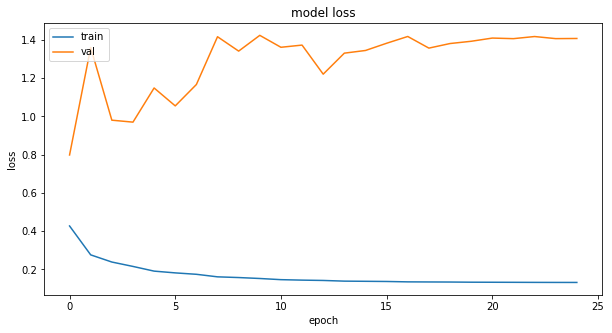

In [21]:
# summarize history for loss
fig = plt.figure(figsize=(10, 5))
plt.plot(train.history['loss'])
plt.plot(train.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

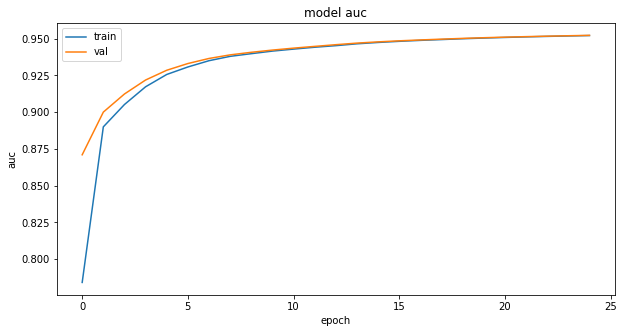

In [22]:
# summarize history for auc
fig = plt.figure(figsize=(10, 5))
plt.plot(train.history['auc'])
plt.plot(train.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()